## Wobble with a variable telluric spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wobble
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = 'hip54287'
niter=100
data = wobble.Data(starname+'_e2ds.hdf5', filepath='../data/', orders=[56])
model = wobble.Model(data)
model.add_star(starname)
model.add_telluric('tellurics', rvs_fixed=True, variable_bases=3)
nll_history, rvs_history, template_history, chis_history = wobble.optimize_order(model, data, 0, 
                niter=niter, output_history=True)

  0%|          | 0/100 [00:00<?, ?it/s]

--- ORDER 0 ---


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


In [3]:
session = wobble.get_session()
c = model.components[1]

(-0.2, 0.2)

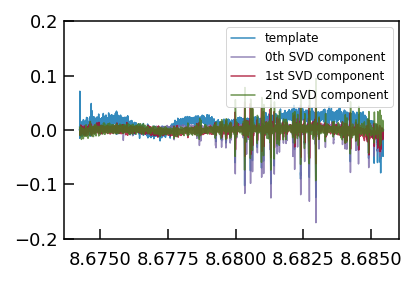

In [4]:
plt.plot(session.run(c.template_xs[0]), session.run(c.template_ys[0]), label='template')
plt.plot(session.run(data.xs[0][0]), session.run(c.basis_vectors[0][0,:]), alpha=0.8, label='0th SVD component')
plt.plot(session.run(data.xs[0][0]), session.run(c.basis_vectors[0][1,:]), alpha=0.8, label='1st SVD component')
plt.plot(session.run(data.xs[0][0]), session.run(c.basis_vectors[0][2,:]), alpha=0.8, label='2nd SVD component')
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.2,0.2])
#plt.xlim([8.681, 8.6816])

In [5]:
from IPython.display import HTML
template_xs = session.run(model.components[0].template_xs[0])
model_ani = wobble.plot_template_history(template_xs, template_history, niter, 50)
HTML(model_ani.to_html5_video())

In [6]:
rvs_ani = wobble.plot_rv_history(data, rvs_history, niter, 50)
HTML(rvs_ani.to_html5_video())

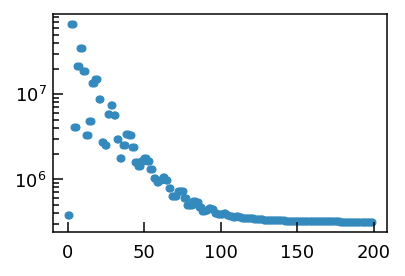

In [7]:
plt.scatter(np.arange(len(nll_history)), nll_history)
plt.yscale('log')

In [9]:
data_xs = session.run(data.xs[0])
chis_ani = wobble.plot_chis_history(0, data_xs, chis_history, niter, 50)
HTML(chis_ani.to_html5_video())